In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

from sklearn.preprocessing import MinMaxScaler

from sklearn.linear_model import Lasso

from sklearn.metrics import mean_squared_error, r2_score
from math import sqrt

import joblib

pd.pandas.set_option('display.max_columns', None)

import warnings
warnings.simplefilter(action='ignore')

In [5]:
data = pd.read_csv('train_titanic.csv')
print(data.shape)
data.head()

(891, 12)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [6]:
X_train, X_test, y_train, y_test = train_test_split(
    data,
    data['Survived'],
    test_size=0.1,
    random_state=0)

X_train.shape, X_test.shape

((801, 12), (90, 12))

In [7]:
X_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
815,816,0,1,"Fry, Mr. Richard",male,NaN,0,0,112058,0.0000,B102,S
877,878,0,3,"Petroff, Mr. Nedelio",male,19.0,0,0,349212,7.8958,NaN,S
193,194,1,2,"Navratil, Master. Michel M",male,3.0,1,1,230080,26.0000,F2,S
523,524,1,1,"Hippach, Mrs. Louis Albert (Ida Sophia Fischer)",female,44.0,0,1,111361,57.9792,B18,C
634,635,0,3,"Skoog, Miss. Mabel",female,9.0,3,2,347088,27.9000,NaN,S


In [8]:
# nacitanie vybranych atributov
features = pd.read_csv('selected_features.csv', header=None)
features = features[0].to_list() 
features.remove('0')
print('Number of features: ', len(features))
print('features: ', features)

Number of features:  7
features:  ['Pclass', 'Sex', 'Age', 'SibSp', 'Cabin', 'Embarked', 'Age_na']


In [9]:
vars_with_na = [
        var for var in data.columns
        if X_train[var].isnull().sum() > 0 and X_train[var].dtypes == 'O'
    ]
print('missing values in train: \n', X_train[vars_with_na].isnull().sum())
print('missing values in test: \n', X_test[vars_with_na].isnull().sum())

X_train[vars_with_na] = X_train[vars_with_na].fillna('Missing')
X_test[vars_with_na] = X_test[vars_with_na].fillna('Missing')

print('\nCHECK - missing values in train: \n', X_train[vars_with_na].isnull().sum())
print('\nCHECK - missing values in test: \n', X_test[vars_with_na].isnull().sum())

missing values in train: 
 Cabin       622
Embarked      2
dtype: int64
missing values in test: 
 Cabin       65
Embarked     0
dtype: int64

CHECK - missing values in train: 
 Cabin       0
Embarked    0
dtype: int64

CHECK - missing values in test: 
 Cabin       0
Embarked    0
dtype: int64


In [10]:
vars_with_na = [
        var for var in data.columns
        if X_train[var].isnull().sum() > 0 and X_train[var].dtypes != 'O'
    ]
print('missing values in train: \n', X_train[vars_with_na].isnull().sum())
print('missing values in test: \n', X_test[vars_with_na].isnull().sum())

for var in vars_with_na:
    # vypocet mode pre danu premennu
    mode_val = X_train[var].mode()[0]
    X_train[var + '_na'] = np.where(X_train[var].isnull(), 1, 0)
    X_test[var + '_na'] = np.where(X_test[var].isnull(), 1, 0)
    # nahradenie chybajucej hodnoty
    # (in train and test)
    X_train[var] = X_train[var].fillna(mode_val)
    X_test[var] = X_test[var].fillna(mode_val)

print('\nCHECK - missing values in train: \n', X_train[vars_with_na].isnull().sum())
print('\nCHECK - missing values in test: \n', X_test[vars_with_na].isnull().sum())

missing values in train: 
 Age    158
dtype: int64
missing values in test: 
 Age    19
dtype: int64

CHECK - missing values in train: 
 Age    0
dtype: int64

CHECK - missing values in test: 
 Age    0
dtype: int64


In [11]:
cat_vars = [var for var in X_train.columns if X_train[var].dtype == 'O']
print('Nominalne atributy: ', cat_vars)

Nominalne atributy:  ['Name', 'Sex', 'Ticket', 'Cabin', 'Embarked']


In [12]:
def find_frequent_labels(df, var, rare_perc):
    df = df.copy()

    tmp = df.groupby(var)['Survived'].count() / len(df)

    return tmp[tmp > rare_perc].index

In [13]:
for var in cat_vars:
    # najdenie frekventovanych hodnot
    frequent_ls = find_frequent_labels(X_train, var, 0.01)
    print('Frequent label: ', frequent_ls)
    print()

        # nahradenie "rare" hodnot hodnotou "Rare"
    X_train[var] = np.where(X_train[var].isin(
        frequent_ls), X_train[var], 'Rare')

    X_test[var] = np.where(X_test[var].isin(
        frequent_ls), X_test[var], 'Rare')


Frequent label:  Index([], dtype='object', name='Name')

Frequent label:  Index(['female', 'male'], dtype='object', name='Sex')

Frequent label:  Index([], dtype='object', name='Ticket')

Frequent label:  Index(['Missing'], dtype='object', name='Cabin')

Frequent label:  Index(['C', 'Q', 'S'], dtype='object', name='Embarked')



In [14]:
# nahradenie string hodnot cislami tak ze string pre ktore bola priemerna cena nizsia budu mat nizsiu ciselnu hodnotu

def replace_categories(train, test, var, target):

    # zoradenie hodnot premennej na zaklade priemernej ceny domov od najmensej po najvacsiu
    ordered_labels = train.groupby([var])[target].mean().sort_values().index

    # vytvorenie slovnika string - hodnota
    ordinal_label = {k: i for i, k in enumerate(ordered_labels, 0)}

    # nahradenie string danou hodnotou v datasete
    train[var] = train[var].map(ordinal_label)
    test[var] = test[var].map(ordinal_label)

In [15]:
for var in cat_vars:
    replace_categories(X_train, X_test, var, 'Survived')

In [16]:
X_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Age_na
815,816,0,1,0,0,24.0,0,0,0,0.0000,1,0,1
877,878,0,3,0,0,19.0,0,0,0,7.8958,0,0,0
193,194,1,2,0,0,3.0,1,1,0,26.0000,1,0,0
523,524,1,1,0,1,44.0,0,1,0,57.9792,1,2,0
634,635,0,3,0,1,9.0,3,2,0,27.9000,0,0,0


In [17]:
y_train = X_train['Survived']
y_test = X_test['Survived']

In [18]:
scaler = MinMaxScaler()

scaler.fit(X_train[features])

MinMaxScaler()

In [19]:
scaler.data_max_

array([ 3.,  1., 80.,  8.,  1.,  3.,  1.])

In [20]:
scaler.data_min_

array([1.  , 0.  , 0.67, 0.  , 0.  , 0.  , 0.  ])

In [21]:
X_train = scaler.transform(X_train[features])
X_test = scaler.transform(X_test[features])

In [23]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression()
model.fit(X_train, y_train)

# ulozenie modelu
joblib.dump(model, 'linear_regression.pkl')

['linear_regression.pkl']

In [24]:
predictions = model.predict(X_test)

In [25]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, predictions)

TN, FP, FN, TP = confusion_matrix(y_test, predictions).ravel()

print('True Positive(TP)  = ', TP)
print('False Positive(FP) = ', FP)
print('True Negative(TN)  = ', TN)
print('False Negative(FN) = ', FN)

accuracy =  (TP+TN) /(TP+FP+TN+FN)

print('Accuracy of the binary classification = {:0.3f}'.format(accuracy))

True Positive(TP)  =  30
False Positive(FP) =  7
True Negative(TN)  =  44
False Negative(FN) =  9
Accuracy of the binary classification = 0.822


Text(0.5, 1.0, 'Feature Importance')

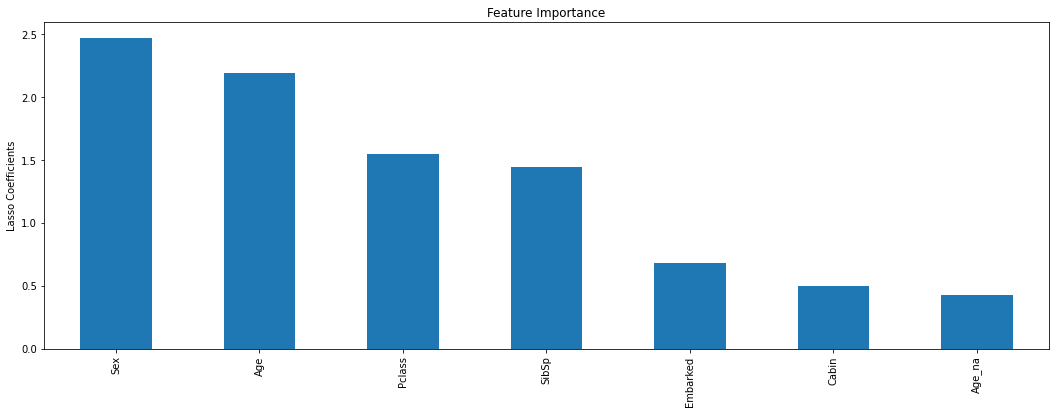

In [26]:
importance = pd.Series(np.abs(model.coef_.ravel()))
importance.index = features
importance.sort_values(inplace=True, ascending=False)
importance.plot.bar(figsize=(18,6))
plt.ylabel('Lasso Coefficients')
plt.title('Feature Importance')